In [1]:
%matplotlib inline
import numpy as np
import scipy.special as sc
import time

Let's go through the steps.

Our data set contains a collection of $n$ data visibilities, each indexed by $Y_j$. It is represented by a column vector of length $n$ as

$$
\vec{Y} = \begin{bmatrix}
Y_1\\
Y_2\\
\vdots\\
Y_j\\
\vdots\\
Y_n
\end{bmatrix}
$$

We assert that the noise on each visibility is Gaussian and independent from every other visibility. This means that $\Sigma$ is a diagonal matrix of size ($n$,$n$), given by
$$
\Sigma=
  \begin{pmatrix}
  \sigma_1^2 & &0\\
  &\ddots& \\
 0 & & \sigma_n^2
  \end{pmatrix},
  \qquad
  \Sigma^{-1}=
  \begin{pmatrix}
  dwgt_1 & &0\\
  &\ddots& \\
 0 & & dwgt_n
  \end{pmatrix} .
$$


In [2]:
#Input data
hiresvis = 'DATA/fullA.vis.npz'
#synthimg = 'DATA/fullA.image.fits'

#Geometric params [Currently hardcoded]
incl = 50.
PA = 70.
offx = -0.3
offy = -0.2


def readinVis(datafile):
    """
    Extracts visibility data from a CASA and python generated .npz file.
    :param datafile: name of .npz file
    """
    datfile = np.load(datafile)
    return datfile['u'], datfile['v'], datfile['Vis'], datfile['Wgt']#, datfile['freq']  

global dvis, dwgt
u, v, dvis, dwgt = readinVis(hiresvis)

We can compare the data to model visibilities.  

The model computes a single complex visibility at a particular radial visibility $\rho_j$ as the sum of $m$ Bessel functions, each indexed by $i$. This also means that in real space, the model has $m$ total bins, each indexed by $i$.

$$
M(\rho_j) = M_j =  \sum_{i=1}^m {w_i \over \rho_j} \left [{r_b}_i J_1(2\pi {r_b}_i \rho_j) - {r_a}_i J_1(2\pi {r_a}_i \rho_j) \right ] = \sum_i w_i x(\rho_j ; r_{i}),
$$

or in matrix form:
$$
\vec{M} = \begin{bmatrix}
M_1\\
M_2\\
\vdots\\
M_j\\
\vdots\\
M_n
\end{bmatrix}
 = \undertilde{X}\vec{w}.
$$

$$
\vec{w}  = \begin{bmatrix}
w_{1} \\
\vdots \\
w_i\\
\vdots \\
w_{m}
\end{bmatrix},
\qquad
  \undertilde{X}=
  \begin{pmatrix}
  x (\rho_{1} ;r_{1}) & ... & x(\rho_{1}; r_{i}) & ... & x(\rho_{1} ;r_{m})\\
  \vdots & & & & \vdots \\
  x (\rho_{j}; r_{i}) & &\ddots& & x(\rho_{j}; r_{m}) \\
  \vdots & & & & \vdots \\
  x(\rho_{n} ;r_{1})  & ... & x(\rho_{n}; r_{i}) & ... &  x(\rho_{n} ;r_{m})
  \end{pmatrix}.
$$         

Deproject the visibilities to get the $\rho$.

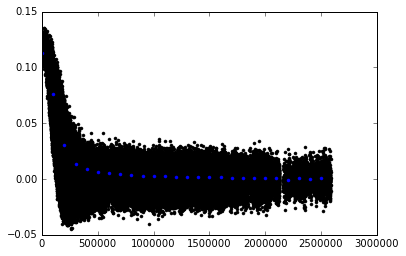

In [118]:
#Deproject the visibilities
arcsec = 180./np.pi*3600.
## convert angles to radians
inclr = np.radians(incl)
PAr = 0.5*np.pi-np.radians(PA)
offrx = offx / arcsec
offry = offy / arcsec
## phase center shift - NOT CURRENTLY USED
shift = np.exp(-2.*np.pi*1.0j*((u*-offrx) + (v*-offry))) 
## coordinate change to deal with projection, rotation, and shifts
uprime = (u*np.cos(PAr) + v*np.sin(PAr)) 
vprime = (-u*np.sin(PAr) + v*np.cos(PAr)) * np.cos(inclr)


#Binned visibilities
from deprojectVis import deproject_vis
rho = np.sqrt(u**2 + v**2)
newbins = np.arange(1., np.amax(np.sqrt(u**2 + v**2))/1000, 100.)
dprj_vis = deproject_vis([u, v, dvis, dwgt], newbins, incl, PA, offx, offy)
dpjrho, dpjvis, dpjsig = dprj_vis
plt.plot(rho, dvis.real,'.k')
plt.plot(dpjrho, dpjvis.real, '.b')

#Assign data vec and matrix
#y = dvis.real[:, np.newaxis] #THIS IS ONLY REALS RIGHT NOW!
#sigma = np.diag(1./dwgt.real)
y = dpjvis.real[:, np.newaxis] #THIS IS ONLY REALS RIGHT NOW!
sigma = np.diag(dpjsig.real*dpjsig.real)


rho = dpjrho/arcsec#np.sqrt(uprime**2 + vprime**2)/arcsec
M = rho.size #Currently in this code M and N are REVERSED from m&n notation used in the text

Choose the bins.

In [119]:
#Choose bins
binmin = 0.1
binmax = 1.1
rin = .01/140.
nbins = 30
b = np.linspace(binmin, binmax, num=nbins-1) 
rleft = np.insert(b[:-1],0,rin)
rright = b
global cb
cb = 0.5*(rleft + rright)
#initfile = np.load('init_fullA_22.npz')
#rleft = np.insert(initfile['b'][:-1],0, initfile['rin'])
#rright = initfile['b']
#cb = initfile['cb']
    
N = rright.size



We assume that the data visibilities are drawn from a (multi-dimensional) normal distribution
$$
\vec{Y}  = \begin{bmatrix}
           Y_{1} \\
           \vdots \\
           Y_{n}
         \end{bmatrix} \sim N \left (\undertilde{X}\vec{w},\undertilde{\Sigma} \right),
$$
with a covariance matrix $\Sigma$

The posterior is given by
$$
P\left(\vec{w}\rvert\vec{Y}\right) \propto P\left(\vec{Y}\rvert\vec{w}\right) \cancelto{1}{P(\vec{w})} \propto N\left(\vec{Y}\rvert X\vec{w}, \Sigma \right)
$$

The maximum-likelihood solution to this type of problem is given by the least-squares solution (see Hogg's Data Analysis, Section 1).
$$
N\left(\vec{Y}\rvert X\vec{w}, \Sigma \right) \propto N\left(\vec{w} \rvert \hat{w},\undertilde{V_w}\right)
$$
where the mean is given by the length-$m$ column vector
$$
\hat{w} = (\undertilde{X}^T \Sigma^{-1} \undertilde{X})^{-1}  \undertilde{X}^T  \Sigma^{-1} \vec{Y}
$$
and the covariance matrix is given by the shape ($m,m$) matrix
$$
\undertilde{V_w} = \undertilde{X}^T \Sigma^{-1} \undertilde{X}
$$


In [120]:
#Calculate x, V, and w_hat
global x
x = np.empty([M,N])
intermed = np.empty([M,N])
rhsright = np.empty(M)
for j in range(M):
    for i in range(N): 
        x[j][i] = 1./rho[j]*(rright[i]*sc.j1(rho[j]*2.*np.pi*rright[i]) - rleft[i]*sc.j1(rho[j]*2.*np.pi*rleft[i]))
        intermed[j][i] = dwgt.real[j]*x[j][i]
        rhsright[j] = dwgt.real[j]*y[j]
global lhs
lhs = np.linalg.inv(np.dot(np.transpose(x),intermed))  #This is Vw undertilde inverse
rhs = np.dot(np.transpose(x), rhsright)
global result
result = np.dot(lhs, rhs) #This is w_hat
print result
del intermed, rhs

[ -7.34008789e+00   4.17075195e+01  -7.99746094e+01   1.14328125e+02
  -1.42781250e+02   1.63734375e+02  -1.72281250e+02   1.85062500e+02
  -1.95437500e+02   1.98875000e+02  -1.96750000e+02   1.86062500e+02
  -1.69562500e+02   1.48375000e+02  -1.24875000e+02   1.03625000e+02
  -8.26250000e+01   6.50000000e+01  -4.96250000e+01   3.43437500e+01
  -2.09843750e+01   1.09687500e+01  -4.06250000e+00   1.25000000e-01
   3.50000000e+00  -5.12500000e+00   3.00000000e+00  -3.37500000e+00
   2.62500000e+00]


Above we assumed the prior is a constant function.  If we instead assume the prior is a multi-dimensional Gaussian, the prior becomes:
$$
P(\vec{w}) = N\left(\vec{w} | \vec{\mu}, \undertilde{C} \right)
$$


This ($m$,$m$) sized covariance matrix $\undertilde{C}$ is a function of the hyperparameters, $\undertilde{C}(a, l, \sigma_w)$ and evaluated at each pair of bin points:
$$
\undertilde{C} = \begin{bmatrix}
k(w_1, w_1) & ... & k(w_1, w_m)\\
\vdots & \ddots &  \vdots \\
k(w_m, w_1) & ... & k(w_m, w_m)\\
\end{bmatrix}
$$
which uses the squared-exponential kernel:
$$
k(w_a, w_b | a, l, \sigma_w) = a^2 \exp \left (-\frac{(w_a - w_b)^2}{2 l^2} \right) + \sigma_w^2 \delta_{ab}
$$

The posterior is described by a new multi-dimensional Gaussian
$$
P\left(\vec{w}\rvert\vec{Y}\right) \propto N\left(\vec{w} \rvert \tilde{w},\undertilde{S_w}\right)
$$
with covariance matrix
$$
\undertilde{S_w}^{-1} = \undertilde{V_w}^{-1} + \undertilde{C}^{-1}
$$
and mean
$$
\tilde{w} = \undertilde{S_w} \left[ \undertilde{V_w}^{-1} \hat{w} + \undertilde{C}^{-1} \vec{0} \right] = \undertilde{S_w} \undertilde{V_w}^{-1} \hat{w}
$$


For some values of $a$ and $l$ and the chosen mean:

In [142]:
#Hyperparameters
gpa = 0.05
gam = 1.
gpl = .15

#True SB
flux = 0.12
sig = 0.6
incl = 50.
PA = 70.
offx = -0.3
offy = -0.2
nominal_SB = (sig/cb)**0.7 * np.exp(-(cb/sig)**2.5)	# fullA distribution
int_SB = np.trapz(2.*np.pi*nominal_SB*cb, cb)		# a check on the total flux
nominal_SB *= flux / int_SB
meanw = nominal_SB #What to use for the mean in C, the bin intensities' covariance matrix

We calculate the new mean and covariance matrix with:

In [122]:
def kexp2(i1, i2, ibins=None, a=None, l=None, gamma=None):
    ri = ibins[i1]
    rj = ibins[i2]
    return ri**gamma*a*a * np.exp(-((ri - rj)**2.)/(2.*l*l)) #Doesn't have cross term

def calccovar(binsin, ain, lin, gamin):
    '''
    Calculate the covariance matrix using a squared exponential kernel
    a: normalization amplitude
    l: correlation length
    '''
    nbins = binsin.shape[0]
    cov = np.fromfunction(kexp2,(nbins,nbins), ibins=binsin, a=ain, l=lin, gamma = gamin, dtype = np.int)
    return cov

def calcwtilde(gpain, gplin, meanwin):
    #Calculate covariance
    global C, Swinv
    C = calccovar(cb, gpain, gplin, gam)
    Cinv = np.linalg.inv(C)
    Swinv = lhs + Cinv

    #Return new mean (wtilde)
    intermed2 = np.dot(Cinv,meanwin)
    wtilde = np.dot(np.linalg.inv(Swinv),np.dot(lhs,result)) + np.dot(np.linalg.inv(Swinv),intermed2)
    return wtilde

[ 1747029.03373718  5074354.65249634  3164417.28735352 -1284863.86828613
 -5354894.07119751 -6927738.54776001 -5851730.89587402 -3057184.78752136
   406119.9516983   3487772.01538086  5150080.659729    4852016.787323
  2965471.17254639   473263.93266296 -1783928.03677368 -3530061.47180176
 -4852709.10736084 -5786383.83514404 -6171441.0625     -5845037.94348145
 -4872756.02218628 -3571642.57531738 -2331674.62985229 -1412646.16609192
  -864202.28219604  -580871.80215454  -406293.92226028  -204562.13180256
   118928.72927856]


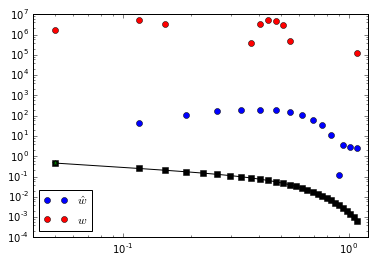

In [141]:
wtilde = calcwtilde(gpa, gpl, meanw)
print wtilde
#Plot output
plt.figure(1)
#plt.subplot(2,1,1)
plt.plot(cb, nominal_SB, 'ks')
plt.plot(cb, nominal_SB, '-k')
plt.plot(cb, result, 'bo', label=r"$\hat{w}$")
plt.plot(cb, wtilde, 'ro', label=r"${w}~w/GP$")
plt.plot(cb[0],[.47],'*g')
ax = plt.gca()
plt.xlim(.4*b[0], 1.1*b[-1])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower left")

plt.subplot(311)
plt.title('Draws from C')
for draw in np.random.multivariate_normal(np.zeros_like(result), C, size=20):
    plt.plot(cb, draw, color="0.5")

plt.plot(cb, nominal_SB-result, 'bo')

plt.subplot(312)        
plt.title('Draws from Vw')
for draw in np.random.multivariate_normal(result, np.linalg.inv(lhs), size=20):
    plt.plot(cb, draw, color="0.5")

plt.plot(cb, result, color="b", label=r"$\hat{w}$")
plt.plot(cb, wtilde, color="r", label=r"${w}~w/GP$")
plt.plot(cb, nominal_SB, color="k", label="truth")


plt.subplot(313)
plt.title('Draws from Sw')
this = np.random.multivariate_normal(wtilde, np.linalg.inv(Swinv), size=10000)

for draw in np.random.multivariate_normal(wtilde, np.linalg.inv(Swinv), size=20):
    plt.plot(cb, draw, color="0.5")
plt.plot(cb, result, color="b", label=r"$\hat{w}$", marker = 'o', linestyle='-')
plt.plot(cb, wtilde, color="r", label=r"${w}~w/GP$", marker = 'o', linestyle='-')
plt.plot(cb, nominal_SB, color="k", label="truth")


plt.legend(loc="upper right")



#Plot corner diagram
import corner
fig = corner.corner(this, show_titles=True, quantiles=(0.16, 0.84))


k1 = np.zeros([M,N])
#k1 = np.dot(x,C)
for j in xrange(M):
    for i in xrange(N): 
        k1[j][i] = np.dot(x[j],C[:,i])
k = np.zeros([M,M])        
tic =  time.time()
print tic
for mm1 in xrange(M):
    if (mm1%100==0):
        print mm1
        print (time.time()-tic)/60
    for mm2 in xrange(M):
        k[mm1][mm2] = np.dot(k1[mm2],x[mm1])

In [134]:
#Calculate the evidence as a function of GP amplitude and length
def calcZ(theta, cb):
    ggpa = theta[0]
    ggpl = theta[1]
    C = calccovar(cb, ggpa, ggpl, 1.)
    K = np.zeros([M,M])  
    K = sigma + np.dot(np.dot(x,C),np.transpose(x))
    (sign,logdet) = np.linalg.slogdet(2.*np.pi*K)
    logZ = -.5*(logdet+np.dot(np.dot(np.transpose(y),np.linalg.inv(K)),y))
#    if (sign<0): print "Warning, negative determinant"
    return logZ

[ -8.88178420e-16   3.00000000e-03]
[ 0.46467203  0.25126902  0.20544873  0.17348222  0.14913782  0.12946328
  0.11289174  0.09852997  0.08584555  0.07451249  0.06432783  0.05516304
  0.04693398  0.03958164  0.03305944  0.027325    0.02233507  0.0180427
  0.01439622  0.01133944  0.00881269  0.00675444  0.00510312  0.0037989
  0.00278532  0.00201053  0.00142824  0.00099812  0.00068596]


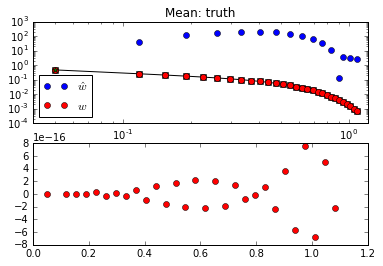

In [154]:
#Minimize the evidence for GP amplitude and length
from scipy.optimize import minimize
thetaguess = np.array([1,.002])
opt = minimize(calcZ, thetaguess, args=(cb), method='Nelder-Mead', tol=1e-6)
print opt.x

#Examine new output
wtilde = calcwtilde(opt.x[0], opt.x[1], meanw)
print wtilde
#Plot output
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(cb, nominal_SB, 'ks')
plt.plot(cb, nominal_SB, '-k')
plt.plot(cb, result, 'bo', label=r"$\hat{w}$")
plt.plot(cb, wtilde, 'ro', label=r"${w}~w/GP$")
plt.plot(cb[0],[.47],'*g')
ax = plt.gca()
plt.xlim(.4*b[0], 1.1*b[-1])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower left")
plt.title('Mean: truth')

#Plot residuals
plt.subplot(212)
plt.plot(cb, nominal_SB-wtilde, 'ro')
plt.savefig("hyperparamopt_meantruth.png")

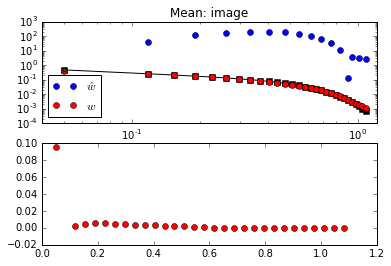

In [155]:
import d3sbfxns as f
synthimg = 'DATA/fullA.image.fits'
rsb, sb, beaminfo = f.sbdata(synthimg, PA, incl, offx, offy)
sbbin, sigmabin = f.sbmeanbin(rin, b, rsb, sb)
wtilde = calcwtilde(opt.x[0], opt.x[1], sbbin)
plt.subplot(211)
plt.plot(cb, nominal_SB, 'ks')
plt.plot(cb, nominal_SB, '-k')
plt.plot(cb, result, 'bo', label=r"$\hat{w}$")
plt.plot(cb, wtilde, 'ro', label=r"${w}~w/GP$")
plt.plot(cb[0],[.47],'*g')
ax = plt.gca()
plt.xlim(.4*b[0], 1.1*b[-1])
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower left")
plt.title('Mean: image')

#Plot residuals
plt.subplot(212)
plt.plot(cb, nominal_SB-wtilde, 'ro')
plt.savefig("hyperparamopt_meanimage.png")